# Lab 8
Cameron Matson

Zihao Mao

Yichen Duan

## Sentiment Analysis on Music Reviews

Our data set consists of every review from pitchfork.com since 1999, a total of 18,393 reviews of muisc albums.  Accompanied with the full lenght review, each album is rated on a scale from 0 to 10, 10 being the highest.  What we'd like to do is use a recurrent neural network to predict, from the text of the review itself, whether the reviewer gave the album a high score (7-10), a neutral score (4-7), or a low score (0-3).

One of the most common uses of sentiment analysis is to classify social media posts.  This type of information can then be used by marketing professionals as a sort of consumer survey.  This could potentially be used by music labels as well.  A music label might collect tweets, or facebook posts, or even articles on the web that mention an album that they recently released.  Then they could use our model (trained on the pitchfork reviews) to classify whether there is a consesus (or not) on how the album was recieved.

In terms of metrics, since the business case is essentially to replace human observers of the data, and we probably won't have someone observing the output at the end (because then whats the point) accuracy is probably the best metric to use when evaluating our performance.

## Data prep

The data is stored in two separate `csv` files, one that has the reviews in it, and one that has a bunch of meta data, including the score, in a different one.

In [1]:
import pandas as pd
import numpy as np

reviews = pd.read_csv('../data/reviews.csv', encoding='utf-8')
print('number of reviews:',len(reviews))
reviews.info()
reviews.head()

number of reviews: 18393
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 2 columns):
reviewid    18393 non-null int64
content     18383 non-null object
dtypes: int64(1), object(1)
memory usage: 287.5+ KB


,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [2]:
meta = pd.read_csv('../data/meta.csv')
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18391 non-null object
artist            18391 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [3]:
meta.drop(['title','artist', 'url', 'author', 'author_type', 'best_new_music', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year'], axis=1, inplace=True)
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 2 columns):
reviewid    18393 non-null int64
score       18393 non-null float64
dtypes: float64(1), int64(1)
memory usage: 287.5 KB


,reviewid,score
0,22703,9.3
1,22721,7.9
2,22659,7.3
3,22661,9.0
4,22725,8.1


In [4]:
df = pd.merge(reviews, meta, on='reviewid')
df.drop('reviewid', axis=1, inplace=True)
df.dropna(inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18391 entries, 0 to 18400
Data columns (total 2 columns):
content    18391 non-null object
score      18391 non-null float64
dtypes: float64(1), object(1)
memory usage: 431.0+ KB


,content,score
0,"“Trip-hop” eventually became a ’90s punchline,...",9.3
1,"Eight years, five albums, and two EPs in, the ...",7.9
2,Minneapolis’ Uranium Club seem to revel in bei...,7.3
3,Kleenex began with a crash. It transpired one ...,9.0
4,It is impossible to consider a given release b...,8.1


Finally lets group the score column so that we have a categorical target variable.  And then take a look at the distribution of the classes we set up.

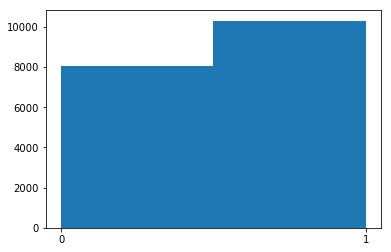

In [5]:
import matplotlib.pyplot as plt

NUM_CLASSES = 2
THRESH = 7
labels = np.arange(NUM_CLASSES)
df['target'] = pd.cut(df.score, [-1, 7.0, 10.0], labels=labels)
#df['target'] = pd.cut(df.score, NUM_CLASSES, labels=labels)
df.head()

plt.hist(df.target, bins=NUM_CLASSES)
plt.xticks(labels)
plt.yticks()
plt.show()

What we've decided to do here is make it a binary classification problem, but to set the threshold at a review score of 7.  This is because most albums get pretty favorable reviews.  You can see this in the distribution, as even when the top bin accounts for more than half of all reviews.  When we do our cross-validation we'll use stratified splits so it shouldn't be that important, but we'll cover it anyway.

In [6]:
#finally lets reduce the number of articles we're working with
NUM_SAMPLES = 5000
df = df.sample(n=NUM_SAMPLES, random_state=42)

In [7]:
# this is an array of the reviews
texts = df.content.values
texts[0]

'The Waco Brothers should be awful. There shouldn\'t be any way possible on\n    God\'s green earth that a British art-punk with anarchosyndicalist leanings\n    could put together a band that includes an acknowledged ex-member of KMFDM\n    on pedal steel guitar and make credible-sounding circa-1960 roots country.\n    Worse, this lot of expats do it a lot better than most Americans of the same\n    ilk.\n    \n    Admit it. It rankles a little bit when someone from exotic climes with his or\n    her own cultural legacy waiting to be exploited comes along and exploits ours\n    better than we do. By all rights, Jon Langford\'s roots project ought to be a\n    collection of rockin\' madrigals and ballads about flowers. We\'ve got a brace\n    of alt-country upstarts who can defame our glorious traditions just fine,\n    thanks. Where does this pack of goofy bastards get off thinking they can\n    one-up our national heritage?\n    \n    But they do, damn it. Jon Langford has always uti

Now we'll use Keras's tokenizer module and pad_sequences to convert the texts into integer sequences of all the same length which makes the computation much easier and quicker

In [8]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [9]:
NUM_WORDS = 1000
MAX_ART_LEN = 500

tkn = Tokenizer(num_words=NUM_WORDS)
tkn.fit_on_texts(texts)

sequences = tkn.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = np.asanyarray(df.target)
y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Shape of data tensor: (5000, 500)
Shape of label tensor: (5000, 2)
999


## RNN stuff

Okay now our data is ready to use for in the rnn.

We'll design two networks one using a LSTM cell and one using a GRU.  For each of them we'll try a few different hyper parameters first on each of them to see if we can find the best architecture.  After that we'll do a cross validation loop of five iterations on an 80/20 train/test split to evaluate the general performance

The parameters we'll investigate are dropout/recurrent_dropout (we'll move these together as one variable) and the output dimension of the RNN cell.

Both the LSTM and GRU architectures will have the same overall structure
- embedding (which will be shared between the two architectures)
- the rnn cell
- 2 dense layers (one with a hidden number of neurons and the final with the number of classes)

### Hyper parameter tuning

In [15]:
# hyper parameters
#dropout_rates = [0.0, 0.2, 0.6]
#latent_dims = [20, 30, 50]

dropout_rates = [0.2]
latent_dims = [50]

In [21]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50

#archs = ['LSTM', 'GRU']
archs = ['LSTM']

dropout = dropout_rates[0]
latent_dim = latent_dims[0]

input_holder = Input(shape=(MAX_ART_LEN, ), name='in')
shared_embed = Embedding(NUM_WORDS, 
                         EMBED_SIZE, 
                         input_length=MAX_ART_LEN, name='embed')(input_holder)

            


In [22]:
rnns = []
for arch in archs:
    for dropout in dropout_rates:
        for latent_dim in latent_dims:
            func = eval(arch)
            rnn_cell = func(latent_dim, dropout=dropout, recurrent_dropout=dropout, name=arch)(shared_embed)
            hidden = Dense(50, activation='relu', name='hidden')(rnn_cell)
            out = Dense(NUM_CLASSES, activation='softmax', name='out')(hidden)

            rnn=Model(inputs=input_holder, outputs=out)
            rnn.compile(loss='binary_crossentropy', 
                          optimizer='rmsprop', 
                          metrics=['accuracy'])

            print('******', arch, ':', dropout, ',', latent_dim, '********')
            print(rnn.summary())
            rnns.append((rnn, (arch, dropout, latent_dim)))


****** LSTM : 0.2 , 50 ********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 500)               0         
_________________________________________________________________
embed (Embedding)            (None, 500, 50)           50000     
_________________________________________________________________
LSTM (LSTM)                  (None, 50)                20200     
_________________________________________________________________
hidden (Dense)               (None, 50)                2550      
_________________________________________________________________
out (Dense)                  (None, 2)                 102       
Total params: 72,852
Trainable params: 72,852
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
len(rnns)

1

In [24]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.35, stratify=y_ohe)

In [25]:
import sklearn.metrics as mt

accuracies = []

for rnn in rnns:
    print('\n\nfitting ', rnn[1])
    rnn[0].fit(X_train, y_train, batch_size=100, epochs=3, validation_data=[X_test, y_test])
    
    yhat = np.round(rnn[0].predict(X_test))
    acc = mt.accuracy_score(yhat, y_test)
    accuracies.append((acc, rnn[1]))



fitting  ('LSTM', 0.2, 50)
Train on 3250 samples, validate on 1750 samples
Epoch 1/3
3250/3250 [==============================] - 33s 10ms/step - loss: 0.6824 - acc: 0.5735 - val_loss: 0.6843 - val_acc: 0.5491
Epoch 2/3
3250/3250 [==============================] - 29s 9ms/step - loss: 0.6581 - acc: 0.6046 - val_loss: 0.6660 - val_acc: 0.5874
Epoch 3/3
3250/3250 [==============================] - 30s 9ms/step - loss: 0.6014 - acc: 0.6895 - val_loss: 0.6585 - val_acc: 0.6251


In [26]:
from datetime import datetime
import os
for rnn in rnns:
    name = rnn[1][0]+'_'+str(rnn[1][1])+'_'+str(rnn[1][2])+'.h5'
    print(name)
    path_name = './models/'+str(datetime.now().date())+str(datetime.now().second)
    os.mkdir(path_name)
    rnn[0].save(path_name + '/' + name)

LSTM_0.2_50.h5


FileNotFoundError: [WinError 3] The system cannot find the path specified: './models/2017-12-0530'

### "You're the best. AROUND!"

Let's pick the best one (in terms of overall accuracy) and visualize how it did and how its perfromance might generalize.

In [27]:
BEST_IDX = np.argmax([a for (a, n) in accuracies])

print('The best model we made was...', accuracies[BEST_IDX][1])
print('...with a performance of ', accuracies[BEST_IDX][0])

best_model = rnns[BEST_IDX][0]

The best model we made was... ('LSTM', 0.2, 50)
...with a performance of  0.625142857143


#### Visualize

In [28]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
def confusion_matrix_plot(rnn, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    yhat2 = np.round(rnn.predict(X_test))
    yhat = np.argmax(rnn.predict(X_test), axis=1)
    rec_rnn = mt.accuracy_score(y_test,yhat2)
    plt.subplot(1,3,1)
    cm = mt.confusion_matrix(np.argmax(y_test, axis=1),yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title('RNN: '+str(rnn))
 

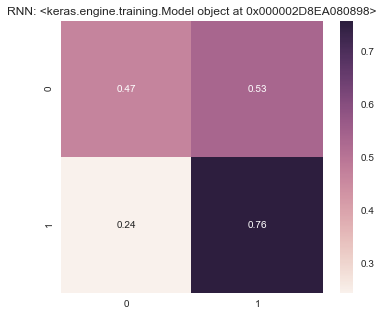

In [29]:
confusion_matrix_plot(best_model, X_test, y_test, enc)

#### Cross Validation

Now we'll pick the best model and do cross validation to see how the performance of it might generalize.  We'll use a stratified 5-fold cv loop.  We'll use K-fold because we've limited our dataset size to speed things up a bit and that way we can train on all of the data that we do have.

In [30]:
from sklearn.model_selection import StratifiedKFold

NUM_SPLITS = 2
skf = StratifiedKFold(NUM_SPLITS, shuffle=False)

cv_acc = []

for i, (train, test) in enumerate(skf.split(X, y)):
    X_train = X[train]
    X_test = X[test]
    y_train = keras.utils.to_categorical(y[train])
    y_test = keras.utils.to_categorical(y[test])
    
    print('\n\nCV ', i+1)
    best_model.fit(X_train, y_train, batch_size=100, epochs=1, validation_data=[X_test, y_test])
    
    yhat = np.round(rnn[0].predict(X_test))
    acc = mt.accuracy_score(yhat, y_test)
    cv_acc.append(acc)
   




CV  1
Train on 2499 samples, validate on 2501 samples
Epoch 1/1
2499/2499 [==============================] - 25s 10ms/step - loss: 0.6188 - acc: 0.6659 - val_loss: 0.6348 - val_acc: 0.6465


CV  2
Train on 2501 samples, validate on 2499 samples
Epoch 1/1
2501/2501 [==============================] - 24s 10ms/step - loss: 0.6351 - acc: 0.6397 - val_loss: 0.5866 - val_acc: 0.7003


In [33]:
cv_acc

[0.64654138344662138, 0.70028011204481788]

In [34]:
print('Accuracy:', np.mean(cv_acc), '+-', np.std(cv_acc))


Accuracy: 0.673410747746 +- 0.0268693642991


## Embeddings Visualization

Lets take a look at how our embedding is doing.  Ideally what we'd like to see is that words with similar meanings are relatively close together in the embedding space while opposite words are far apart.

In [35]:
# grabe the weights of the embedding
embed_layer = best_model.get_layer('embed')  # note that since this was shared,
                                             # it doesn't really matter which model we pick it from
weights = embed_layer.get_weights()[0]

The function below takes four words as inputs, consisting of two pairs of "opposites."  The two pairs themselves should have similar connotations though.

In [36]:
def visualize_weights(w1, w2, w3, w4):
    # get the index of each word
    p1 = tkn.word_index[w1]
    p2 = tkn.word_index[w2]
    p3 = tkn.word_index[w3]
    p4 = tkn.word_index[w4]
    
    # embedding vectors
    e1 = weights[p1]
    e2 = weights[p2]
    e3 = weights[p3]
    e4 = weights[p4]

    # we'll project into the space defined by the greatest distance between each pair
    distance1 = np.abs(e1 - e2)
    distance2 = np.abs(e3 - e4)
    
    d1 = np.argmax(distance1)
    d2 = np.argmax(distance2)

    # projections of each vector into the plane
    e1_2d = (e1[d1], e1[d2])
    e2_2d = (e2[d1], e2[d2])
    e3_2d = (e3[d1], e3[d2])
    e4_2d = (e4[d1], e4[d2])

    # plot
    plt.scatter([e1_2d[0], e2_2d[0], e3_2d[0], e4_2d[0]],[e1_2d[1], e2_2d[1], e3_2d[1], e4_2d[1]])
    plt.annotate(w1, e1_2d)
    plt.annotate(w2, e2_2d)
    plt.annotate(w3, e3_2d)
    plt.annotate(w4, e4_2d)
    plt.show()

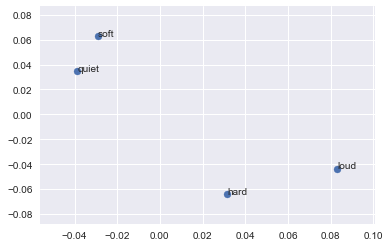

In [37]:
w1 = 'loud'
w2 = 'quiet'
w3 = 'hard'
w4 = 'soft'

visualize_weights(w1, w2, w3, w4)